cuda:0


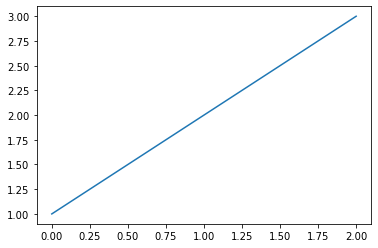

In [1]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env_new import RealExpEnv
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [679]:
import Environment.data_visualization
importlib.reload(Environment.data_visualization)
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step

In [701]:
import Environment.Env_new
importlib.reload(Environment.Env_new)
from Environment.Env_new import RealExpEnv

In [30]:
import RL.sac
importlib.reload(RL.sac)
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory

In [702]:
# run this if want to reset env but keep the memory
amd_accuracy = copy.copy(env.accuracy)
print(amd_accuracy)
amd_true_positive = copy.copy(env.true_positive)
print(amd_true_positive)
amd_true_negative = copy.copy(env.true_negative)
print(amd_true_negative)
amd = copy.copy(env.atom_move_detector)

[0.7121212121212122]
[0.7321428571428571]
[0.6]


succeed to connect
(128, 128)


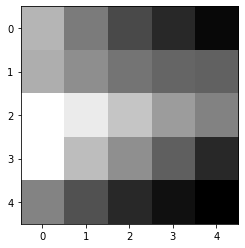

In [694]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (5,3), 5, 5
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [703]:
#test offset extration
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

12.940980911254883 35.566402435302734


In [704]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 3
pixel = 128

im_size_nm = 9.033

offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([9.2, 16.8, 35.9, 43.4]) #[left, right, up, down]
template_max_y = 5
scan_mV = 1000
max_len = 5
pull_back_mV = 10
pull_back_pA = 57000
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0/_atom_move_detector_conv.pth', 
                 bottom=False, random_scan_rate = 0.9, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)


succeed to connect
Load cnn weight


In [705]:
# run this if want to reset env but keep the memory
env.accuracy = amd_accuracy
env.true_positive = amd_true_positive
env.true_negative = amd_true_negative
env.atom_move_detector = amd

In [559]:
c_v, a_v = [], []
for c, a in zip(env.atom_move_detector.currents_val, env.atom_move_detector.atom_move_by_val):
    if (c is not None) and (a is not None):
        c_v.append(c)
        a_v.append(a)
    elif c is None:
        print('c None')
    elif a is None:
        print('a None')

In [535]:
env.atom_move_detector.currents_val = c_v
env.atom_move_detector.atom_move_by_val = a_v

In [450]:
for i, np_name in enumerate(glob.glob(folder_name+'/*.npy')):
    data = np.load(np_name,allow_pickle=True).item()
    transitions = data['transitions']
    for s, a, r, n, d, info in zip(transitions['state'], transitions['action'], transitions['reward'], 
                                   transitions['next_state'], transitions['done'], transitions['info']):
        mask = float(not d)
        memory.push(s, a, r, n, mask)
print(len(memory))

3142


In [587]:
# run this if want to reset env but keep the memory
buffer = memory.buffer
memory = HerReplayMemory(replay_size, env)
memory.buffer = buffer
print(len(memory))

6472


In [5]:
# ONLY RE-RUN if WANT TO RESET the AGENT
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000

agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(folder_name,60)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(folder_name,60)))
agent.alpha = torch.load(''{}/_alpha_{}.pth'.format(folder_name,i_episode))
memory = HerReplayMemory(replay_size, env)

In [6]:
episode_memory = Episode_Memory()
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0'

In [ ]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [688]:
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = max_len
eta = 0.997
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=True)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('Precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                '''show_done(env.img_info, env.atom_absolute_nm, env.atom_start_absolute_nm, 
                          env.destination_absolute_nm, reward, env.template_nm, env.template_wh)'''
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                #c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                #c_k = memory.__len__()
                #print('TRAINING!')
                c_k = max(int(memory.__len__()*eta**(k*(1000/episode_K))), 500)
                print(c_k)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))


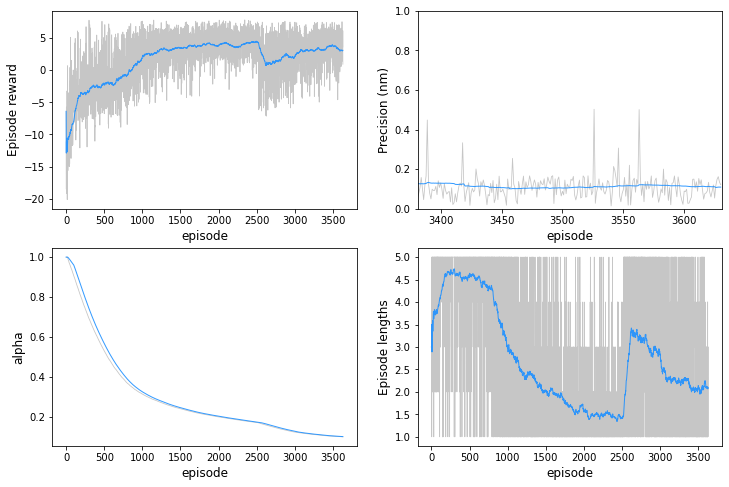

Episode: 3620
goal_nm: 0.5789106222962166


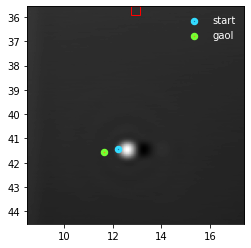

step: 0
55 84 45 88


KeyboardInterrupt: 

In [708]:
sac_train(max_steps=max_len, episode_start = 3501,num_episodes = 1000)

In [709]:
torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv.pth'.format(folder_name))

In [707]:
env.atom_absolute_nm = None

Major tip/ domain change and definitely Co: 2504, some tip change soon after, Makus fix tip at episode 2523
Episode 2649, change emphasize recent experience to be more aggressive
Episode 2740: tip forming and check manipulation in 4 directions at 10 mV 57 nA

In [635]:
episode_rewards_eval, precisions_eval, episode_lengths_eval = [], [], []
avg_episode_rewards_eval, avg_precisions_eval, avg_episode_lengths_eval = [], [], []
folder_name_eval = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/evaluation_2500_stochastic'

step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 3
pixel = 128

im_size_nm = 6.956

offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([-21.5, -16.5, -37, -32.5]) #[left, right, up, down]
template_max_y = 25
scan_mV = 1000
max_len = 5

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, '{}/_atom_move_detector_conv.pth'.format(folder_name), 
                 bottom=False, random_scan_rate = 0)

succeed to connect
Load cnn weight


In [636]:
# ONLY RE-RUN if WANT TO RESET the AGENT
LEARNING_RATE = 0.0003

agent_eval = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent_eval.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(folder_name,2500)))
agent_eval.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(folder_name,2500)))
agent_eval.alpha = torch.load('{}/_alpha_{}.pth'.format(folder_name,2500))

In [637]:
def sac_eval(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent_eval.select_action(state, eval=False)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('Precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name_eval)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                
                break
            else:                
                state=next_state
             
        episode_rewards_eval.append(episode_reward)
        precisions_eval.append(env.dist_destination)
        episode_lengths_eval.append(episode_steps)
        avg_episode_rewards_eval.append(np.mean(episode_rewards_eval))
        avg_precisions_eval.append(np.mean(precisions_eval))
        avg_episode_lengths_eval.append(np.mean(episode_lengths_eval))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards_eval, precisions_eval, np.zeros(10), episode_lengths_eval,
                      avg_episode_rewards_eval, np.zeros(10), avg_precisions_eval, avg_episode_lengths_eval)


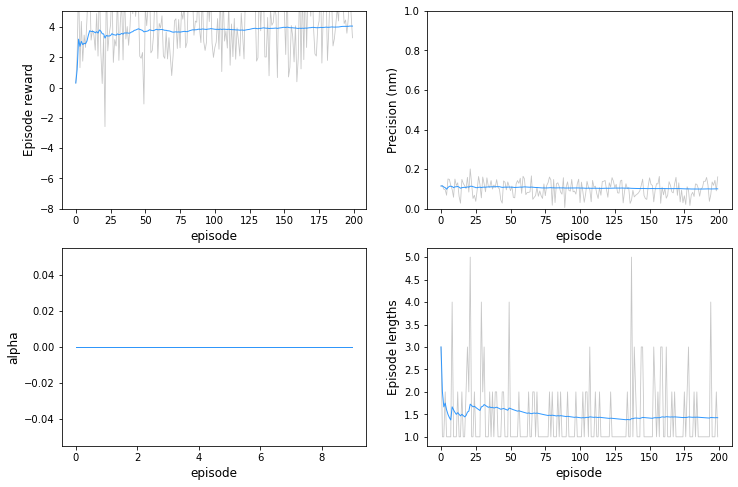

In [638]:
sac_eval(max_steps=max_len, num_episodes = 200, episode_start = 0)

In [639]:
np.sum(np.array(precisions_eval)<env.precision_lim)

199

In [588]:
dist_ds = []
for i, np_name in enumerate(glob.glob(folder_name+'/*.npy')):
    data = np.load(np_name,allow_pickle=True).item()
    end = data['episode_end_info']['atom_absolute_nm']
    goal = data['episode_start_info']['info']['goal_absolute_nm']
    dist_ds.append(np.linalg.norm(end - goal))

(0.0, 2.0)

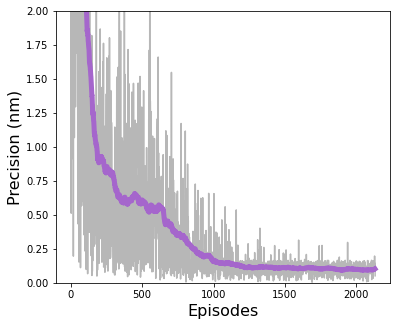

In [590]:
plt.subplots(figsize=(6,5))
plt.plot(dist_ds, color='#707070', alpha=0.5)
plt.plot(np.arange(100,len(dist_ds)-1),np.convolve(dist_ds, np.ones(100))[100:-100]/100, color='#A566CC', linewidth=5)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Precision (nm)', fontsize=16)
plt.ylim([0, 2])
#plt.xlim([0, 750])
# can we draw a horizontal line marking the 'ultimate precision'?
# using i.e. plt.hline()

In [594]:
(np.array(dist_ds[-100:])<env.precision_lim)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True])